In [42]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import math
import numpy as np
from shapely.geometry import Point, LineString, Polygon, box
from shapely.affinity import rotate
import time
import sys
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [43]:
# GLOBALS

# Dimensions of robot (m)
ROBOT_WIDTH = 0.18
ROBOT_HEIGHT = 0.20

# Dimensions of space (m)
SPACE_WIDTH = 6.5
SPACE_HEIGHT = 4.5
 
# Margin of error (m)
MARGIN = 0.03

# Effective dimensions including margin
EFFECTIVE_ROBOT_WIDTH = ROBOT_WIDTH + 2 * MARGIN
EFFECTIVE_ROBOT_HEIGHT = ROBOT_HEIGHT + 2 * MARGIN

# Add these global variables after the existing dimensions
ROBOT_SPEED = 0.02  # meters per frame
PATH_ALPHA = 0.3   # transparency of path lines


# Files

In [44]:
def parse_initial_positions(file_path):
    """
    Parses the initial positions of the robots from a file.

    Args:
        file_path (str): The path to the file containing the initial positions.

    Returns:
        tuple: A tuple containing tuples, each representing the (x, y) coordinates of the initial positions.
            For example: ((x1, y1), (x2, y2), ...)
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # Strip whitespaces, split by commas, cast as floats and turn iterator to list
        x_positions = list(map(float, lines[0].strip().split(',')))
        y_positions = list(map(float, lines[1].strip().split(',')))
    return tuple(zip(x_positions, y_positions))


In [45]:
def parse_target_positions(file_path):
    """
    Parses the target positions of the robots from a file.
    
    Args:
        file_path (str): The path to the file containing the target positions.
    
    Returns:
        list: A list of tuples, each representing the (x, y) coordinates of the target positions.
            For example: [(x1, y1), (x2, y2), ...]
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x_positions = list(map(float, lines[0].strip().split(',')))
        y_positions = list(map(float, lines[1].strip().split(',')))
    return list(zip(x_positions, y_positions))


In [46]:
def parse_obstacles(directory_path):
    """
    Parses the obstacle coordinates definitions from multiple files.
    
    Args:
        directory_path (str): The path to the directory containing zero or more files containing the vertices of the obstacle. Each file follows the naming convention: Obstacle_<number>.txt.
        
    Returns:
        list: A list of lists, each representing an obstacle. Each obstacle is a list of tuples, where each tuple contains the (x, y) coordinates of a vertex.
               For example: [[(x1, y1), (x2, y2), (x3, y3), (x4, y4)], ...]
    """
    obstacles = []
    for file_name in os.listdir(directory_path):
        if file_name.startswith('Obstacle_') and file_name.endswith('.txt'):
            with open(os.path.join(directory_path, file_name), 'r') as file:
                lines = file.readlines()
                x_positions = list(map(float, lines[0].strip().split(',')))
                y_positions = list(map(float, lines[1].strip().split(',')))
                obstacles.append(list(zip(x_positions, y_positions)))
    return obstacles


In [47]:
def ensure_output_directory():
    """Create output directory if it doesn't exist."""
    os.makedirs('output', exist_ok=True)

In [48]:
def load_paths_from_directory(directory):
    """
    Load paths for robots from a specified directory.

    Args:
        directory (str): The path to the directory containing the path files.

    Returns:
        list: A list of paths, where each path is a list of (x, y) coordinates.
    """
    paths = []
    for robot_number in [1, 2]:
        file_path = os.path.join(directory, f"XY_303_2_{robot_number}.txt")
        path = []
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                x, y, _ = line.strip().split(',')
                path.append((float(x), float(y)))
        paths.append(path)
    return paths

In [49]:
def write_trajectory_to_file(path, file_name, group, team, robot):
    ensure_output_directory() 
    
    with open(file_name, 'w') as file:
        for i, (x, y) in enumerate(path):
            if i < 3:
                file.write(f"{x},{y},{group if i == 0 else team if i == 1 else robot}\n")
            else:
                file.write(f"{x},{y},0\n")

# Algorithm

In [50]:
# Node class representing a state in the space
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0

In [51]:
# RRT* algorithm class
class RRTStar:
    def __init__(self, start, goal, obstacles, map_size, step_size=0.05, max_iter=2000, goal_bias=0.1, improvement_threshold=0.01, max_no_improvement_iter=100):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacles = obstacles
        self.map_size = map_size
        self.step_size = step_size
        self.max_iter = max_iter
        self.node_list = [self.start]
        self.goal_region_radius = 0.01  # As per considerations
        self.search_radius = 0.3       # As per considerations
        self.path = None
        self.goal_reached = False
        self.goal_bias = goal_bias
        self.improvement_threshold = improvement_threshold
        self.max_no_improvement_iter = max_no_improvement_iter
        # Convert obstacles to shapely Polygons and add margin
        self.obstacle_polygons = [Polygon(obstacle).buffer(MARGIN) for obstacle in self.obstacles]

    # General utility methods
    def calc_distance(self, node1, node2):
        return math.hypot(node2.x - node1.x, node2.y - node1.y)

    def calc_distance_and_angle(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        distance = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return distance, theta

    # Method updated to use shapely for collision detection
    def is_in_obstacle(self, node):
        """
        Check if the robot at the given node position and orientation intersects any obstacle.
        """
        # Determine the orientation (theta) of the robot
        if node.parent:
            dx = node.x - node.parent.x
            dy = node.y - node.parent.y
            theta = math.degrees(math.atan2(dy, dx))
        else:
            theta = 0  # Default orientation if no parent
        
        # Create a rectangle representing the robot's dimensions at the node's position
        robot_rect = box(
            node.x - EFFECTIVE_ROBOT_WIDTH / 2,
            node.y - EFFECTIVE_ROBOT_HEIGHT / 2,
            node.x + EFFECTIVE_ROBOT_WIDTH / 2,
            node.y + EFFECTIVE_ROBOT_HEIGHT / 2
        )
        # Rotate the rectangle to represent the robot's facing direction
        robot_polygon = rotate(robot_rect, angle=theta, origin=(node.x, node.y))
        
        # Check for collision with any obstacle
        for polygon in self.obstacle_polygons:
            if robot_polygon.intersects(polygon):
                return True
        return False

    # Updated to check collision along the edge between nodes
    def is_collision_free_path(self, node1, node2):
        """
        Check if the path between node1 and node2 is collision-free,
        considering the robot's dimensions and facing at each sampled point.
        """
        distance = self.calc_distance(node1, node2)
        if distance == 0:
            # Nodes are at the same position, check collision at this point
            temp_node = Node(node1.x, node1.y)
            temp_node.parent = node1.parent
            return not self.is_in_obstacle(temp_node)
        num_samples = max(int(distance / self.step_size), 1)
        for i in range(num_samples + 1):
            t = i / num_samples
            x = node1.x + t * (node2.x - node1.x)
            y = node1.y + t * (node2.y - node1.y)
            # Create a temporary node for collision checking
            temp_node = Node(x, y)
            temp_node.parent = node1
            if self.is_in_obstacle(temp_node):
                return False
        return True

    # Updated to use is_collision_free_path for edge collision detection
    def is_collision_free(self, node):
        if self.is_in_obstacle(node):
            return False
        if not (-self.map_size[0]/2 <= node.x <= self.map_size[0]/2 and
                -self.map_size[1]/2 <= node.y <= self.map_size[1]/2):
            return False
        # Check collision along the path from parent to current node
        if node.parent and not self.is_collision_free_path(node.parent, node):
            return False
        return True

    # Methods in the order they are called in plan()
    def get_random_node(self):
        if random.random() < self.goal_bias:
            return Node(self.goal.x, self.goal.y)
        else:
            return Node(
                random.uniform(-self.map_size[0]/2, self.map_size[0]/2),
                random.uniform(-self.map_size[1]/2, self.map_size[1]/2)
            )

    def get_nearest_node(self, rand_node):
        distances = [self.calc_distance(node, rand_node) for node in self.node_list]
        min_index = distances.index(min(distances))
        return self.node_list[min_index]

    def steer(self, from_node, to_node):
        distance, theta = self.calc_distance_and_angle(from_node, to_node)
        distance = min(self.step_size, distance)
        new_node = Node(
            from_node.x + distance * math.cos(theta),
            from_node.y + distance * math.sin(theta)
        )
        new_node.cost = from_node.cost + distance
        new_node.parent = from_node
        return new_node

    def find_neighbors(self, new_node):
        neighbors = []
        for node in self.node_list:
            if self.calc_distance(node, new_node) <= self.search_radius:
                neighbors.append(node)
        return neighbors

    def choose_parent(self, neighbors, nearest_node, new_node):
        best_cost = nearest_node.cost + self.calc_distance(nearest_node, new_node)
        best_node = nearest_node
        for node in neighbors:
            cost = node.cost + self.calc_distance(node, new_node)
            if cost < best_cost and self.is_collision_free_path(node, new_node):
                best_cost = cost
                best_node = node
        new_node.cost = best_cost
        new_node.parent = best_node
        return new_node

    def rewire(self, new_node, neighbors):
        for node in neighbors:
            cost_through_new = new_node.cost + self.calc_distance(new_node, node)
            if cost_through_new < node.cost and self.is_collision_free_path(new_node, node):
                node.parent = new_node
                node.cost = cost_through_new

    def reached_goal(self, node):
        distance = self.calc_distance(node, self.goal)
        return distance <= self.goal_region_radius

    def generate_final_path(self, goal_node):
        path = []
        node = goal_node
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]  # Reverse the path
    
    # Place plan() as the last method
    def plan(self):
        best_cost = float('inf')
        no_improvement_count = 0

        for _ in range(self.max_iter):
            rand_node = self.get_random_node()
            nearest_node = self.get_nearest_node(rand_node)
            new_node = self.steer(nearest_node, rand_node)

            if self.is_collision_free(new_node):
                neighbors = self.find_neighbors(new_node)
                new_node = self.choose_parent(neighbors, nearest_node, new_node)
                self.node_list.append(new_node)
                self.rewire(new_node, neighbors)

                if self.reached_goal(new_node):
                    current_cost = new_node.cost
                    if current_cost < best_cost:
                        best_cost = current_cost
                        self.path = self.generate_final_path(new_node)
                        self.goal_reached = True
                        no_improvement_count = 0
                    else:
                        no_improvement_count += 1

                    if no_improvement_count >= self.max_no_improvement_iter:
                        break


# Graph

In [52]:
def visualize_space(initial_positions, target_positions, obstacles, paths=None, output = 'output/solve.gif'):
    """
    Visualizes the space with the initial positions, target positions, obstacles, paths,
    and animates the robots moving along their paths.
    """
    fig, ax = plt.subplots()
    ax.set_xlim(-SPACE_WIDTH/2, SPACE_WIDTH/2)
    ax.set_ylim(-SPACE_HEIGHT/2, SPACE_HEIGHT/2)
    ax.set_aspect('equal')
    
    # Draw grid points
    for x in range(int(-SPACE_WIDTH), int(SPACE_WIDTH + 1)):
        for y in range(int(-SPACE_HEIGHT), int(SPACE_HEIGHT + 1)):
            ax.plot(x * 0.5, y * 0.5, 'ko', markersize=2)
    
    # Draw initial positions
    for pos in initial_positions:
        circle = patches.Circle(pos, 0.1, edgecolor='black', facecolor='none')
        ax.add_patch(circle)
    
    # Draw target positions
    for pos in target_positions:
        circle = patches.Circle(pos, 0.1, edgecolor='none', facecolor='blue')
        ax.add_patch(circle)
    
    # Draw obstacles
    for obstacle in obstacles:
        polygon = patches.Polygon(obstacle, edgecolor='none', facecolor='red')
        ax.add_patch(polygon)
    
    if paths:
        # Draw paths with reduced alpha
        for i, path in enumerate(paths):
            path_x, path_y = zip(*path)
            color = 'blue' if i == 0 else 'green'
            ax.plot(path_x, path_y, color=color, linewidth=2, alpha=PATH_ALPHA, label=f'Robot {i+1} Path')
        
        # Create robot patches
        robots = []
        robot_colors = ['blue', 'green']
        for i, pos in enumerate(initial_positions):
            robot = patches.Rectangle(
                (pos[0] - ROBOT_WIDTH/2, pos[1] - ROBOT_HEIGHT/2),
                ROBOT_WIDTH,
                ROBOT_HEIGHT,
                edgecolor='none',
                facecolor=robot_colors[i]
            )
            ax.add_patch(robot)
            robots.append(robot)
        
        # Calculate total distance for each path
        path_distances = []
        for path in paths:
            total_dist = 0
            for i in range(len(path)-1):
                dx = path[i+1][0] - path[i][0]
                dy = path[i+1][1] - path[i][1]
                total_dist += math.sqrt(dx*dx + dy*dy)
            path_distances.append(total_dist)
        
        # Calculate number of frames needed
        max_distance = max(path_distances)
        num_frames = int(max_distance / ROBOT_SPEED) + 1
        
        def update(frame):
            # Calculate distance covered
            distance = frame * ROBOT_SPEED
            
            # Update each robot's position
            for robot_idx, (robot, path) in enumerate(zip(robots, paths)):
                # Find position along path at current distance
                current_dist = 0
                current_pos = path[0]
                
                for i in range(len(path)-1):
                    dx = path[i+1][0] - path[i][0]
                    dy = path[i+1][1] - path[i][1]
                    segment_dist = math.sqrt(dx*dx + dy*dy)
                    
                    if current_dist + segment_dist >= distance:
                        # Interpolate position
                        t = (distance - current_dist) / segment_dist
                        current_pos = (
                            path[i][0] + t * dx,
                            path[i][1] + t * dy
                        )
                        break
                    current_dist += segment_dist
                    if i == len(path)-2:  # If at end of path
                        current_pos = path[-1]
                
                # Update robot position
                robot.set_xy((current_pos[0] - ROBOT_WIDTH/2, current_pos[1] - ROBOT_HEIGHT/2))
            
            return robots
        
        # Create and save animation
        ensure_output_directory()  # Add this line
        anim = FuncAnimation(
            fig, update, frames=num_frames,
            interval=20, blit=True
        )
        anim.save(output, writer='pillow')
    
    plt.legend()
    plt.gca().set_facecolor('white')
    plt.show()

# Main

In [53]:
def generate_paths(initial_positions, target_positions, obstacles, order, output_file = 'output/'):
    
    # Define the order for each robot
    robot_1_order, robot_2_order = order
    
    # Reorder target positions for each robot
    robot_1_targets = [target_positions[i - 1] for i in robot_1_order]
    robot_2_targets = [target_positions[i - 1] for i in robot_2_order]
    
    paths = []
    for i, (initial_position, targets) in enumerate(zip(initial_positions, [robot_1_targets, robot_2_targets])):

        path = []
        current_position = initial_position
        robot_number = i + 1
        all_positions = [current_position] + targets

        for j in range(len(targets)):

            start_point = all_positions[j]
            end_point = all_positions[j + 1]

            print(f"Calculating from point {j} to point {j+1} for Robot {robot_number}...")
            
            start_time = time.time()
            rrt_star = RRTStar(
                start=start_point,
                goal=end_point,
                obstacles=obstacles,
                map_size=(SPACE_WIDTH, SPACE_HEIGHT),
                step_size= ROBOT_SPEED * 10,
                max_iter=10000,
                goal_bias=0.1,
                improvement_threshold=0.01,
                max_no_improvement_iter=1000
            )
            rrt_star.plan()
            end_time = time.time()
            if rrt_star.path:
                segment_path = rrt_star.path
                if j > 0:
                    # Avoid duplicate points between segments
                    segment_path = segment_path[1:]
                path.extend(segment_path)
                print(f"Obtained path in {end_time - start_time:.2f} seconds.")
            else:
                print(f"No path found from point {j} to point {j+1} for Robot {robot_number}.")
                break
        if path:
            paths.append(path)
            write_trajectory_to_file(
                path,
                f"{output_file}XY_303_2_{robot_number}.txt",
                robot_number,
                '303',
                '2'
            )
        else:
            print(f"Failed to generate path for Robot {robot_number}.")

Calculating from point 0 to point 1 for Robot 1...
Obtained path in 52.34 seconds.
Calculating from point 1 to point 2 for Robot 1...
Obtained path in 46.04 seconds.
Calculating from point 2 to point 3 for Robot 1...
Obtained path in 53.03 seconds.
Calculating from point 3 to point 4 for Robot 1...
Obtained path in 48.12 seconds.
Calculating from point 4 to point 5 for Robot 1...
Obtained path in 41.28 seconds.
Calculating from point 5 to point 6 for Robot 1...
Obtained path in 43.58 seconds.
Calculating from point 6 to point 7 for Robot 1...
Obtained path in 42.32 seconds.
Calculating from point 0 to point 1 for Robot 2...
Obtained path in 46.21 seconds.
Calculating from point 1 to point 2 for Robot 2...
Obtained path in 48.96 seconds.
Calculating from point 2 to point 3 for Robot 2...
No path found from point 2 to point 3 for Robot 2.


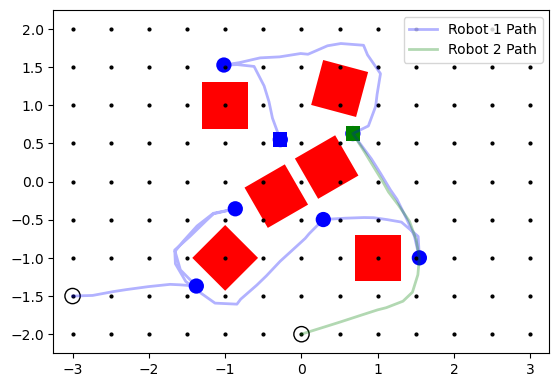

In [55]:
output_folder  = "output/"
input_folder = "files/"
file_format = 'XY_303_2_'

initial_positions = parse_initial_positions(f'{input_folder}InitialPositions.txt')
target_positions = parse_target_positions(f'{input_folder}TargetPositions.txt')
obstacles = parse_obstacles(input_folder)

# Define the order for each robot
robot_1_order = [6, 1, 3, 7, 5, 4, 2]
robot_2_order = [7, 5, 4, 2, 1, 6, 3]
order = (robot_1_order, robot_2_order)

generate_paths(initial_positions, target_positions, obstacles, order, output_folder)
paths = load_paths_from_directory(output_folder)

visualize_space(initial_positions, target_positions, obstacles, paths, output= f'{output_folder}solve.gif')